In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]
import tensorflow
import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 7
input_shape = (50, 50, 3)

In [3]:
train = tensorflow.keras.utils.image_dataset_from_directory("C:/deep learning/4-6hr/train",                                 batch_size = 100,
                                                                 image_size = (50,50),
                                                                 seed=123)
test = tensorflow.keras.utils.image_dataset_from_directory("C:/deep learning/4-6hr/test",                                 batch_size = 100,
                                                                 image_size = (50,50),
                                                                 seed=123)
class_names = train.class_names

Found 1305 files belonging to 7 classes.
Found 675 files belonging to 7 classes.


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 100
num_epochs = 5  # For real training, use num_epochs=100. 10 is a test value
image_size = 50  # We'll resize input images to this size
patch_size = 5  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 3
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 3
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [5]:
# data_augmentation = keras.Sequential(
#     [
#         layers.Normalization(),
#         layers.Resizing(image_size, image_size),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.02),
#         layers.RandomZoom(height_factor=0.2, width_factor=0.2),
#     ],
#     name="data_augmentation",
# )
# # Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [8]:
train = train.map(lambda x,y:((x/255),y))
test = test.map(lambda x,y:((x/255),y))

plt.figure(figsize=(4, 4))
batch1 = train.as_numpy_iterator().next()
 image = train[np.random.choice(range(train.shape[0]))]
 plt.imshow(image.astype("uint8"))
 plt.axis("off")

resized_image = ops.image.resize(
     ops.convert_to_tensor([image]), size=(image_size, image_size)
 )
 patches = Patches(patch_size)(resized_image)
 print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
 print(f"Patches per image: {patches.shape[1]}")
 print(f"Elements per patch: {patches.shape[-1]}")

 n = int(np.sqrt(patches.shape[1]))
fig,ax = plt.subplots(ncols = 4,figsize=(10,10))
for indx,img in enumerate(batch1[0][:4]):
  ax[indx].imshow(img)
  ax[indx].title.set_text(class_names[batch1[1][indx]])

In [9]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [10]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.1342 - loss: 7.8984 - top-5-accuracy: 0.7077 - val_accuracy: 0.1615 - val_loss: 2.1175 - val_top-5-accuracy: 0.8133
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.1615 - loss: 2.5192 - top-5-accuracy: 0.7397 - val_accuracy: 0.1600 - val_loss: 1.9578 - val_top-5-accuracy: 0.8267
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 879ms/step - accuracy: 0.1329 - loss: 2.2234 - top-5-accuracy: 0.7217 - val_accuracy: 0.1600 - val_loss: 1.9842 - val_top-5-accuracy: 0.6904
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 902ms/step - accuracy: 0.1793 - loss: 2.0597 - top-5-accuracy: 0.7511 - val_accuracy: 0.1600 - val_loss: 1.9229 - val_top-5-accuracy: 0.8652
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 909ms/step - accuracy: 0.1654 - loss: 2.0542 - top-5-accuracy: 0.7304 - val_accuracy: 0.1867 - val_loss: 1.9503 - val_top-5-accuracy: 0.7896
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.1752 - loss: 1.9575 - top-5-accuracy: 0.783

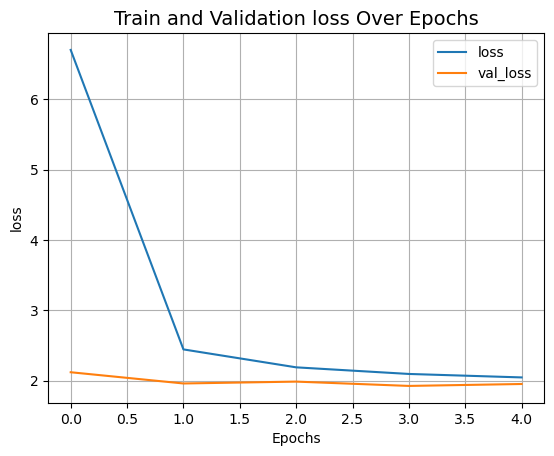

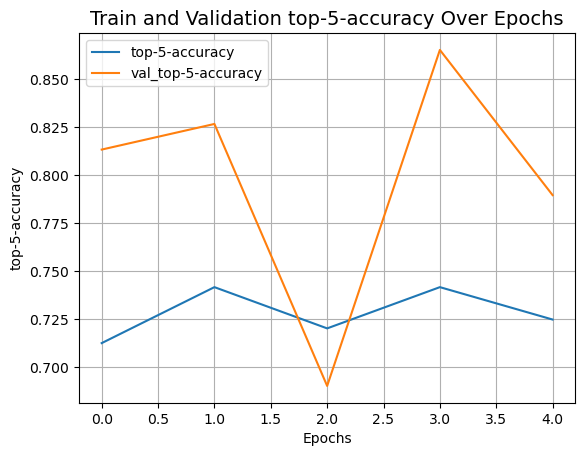

In [11]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=test,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")